# Packages: minimize for better structure

In [71]:
import numpy as np
import os
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
import matplotlib.cm as cm

os.environ["OMP_NUM_THREADS"] = '1'
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
warnings.filterwarnings('ignore')
#sns
import seaborn as sns

# Data initialization

In [72]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

path = '1_csv'
folder = 'C:\\Users\\RJEN0307\\Desktop\\Bachelorprojekt\\Data\\fif files\\epochs_csv\\'

full_path = os.path.join(folder, path)

patient_numbers = []
patient_data = {}

for file in os.listdir(full_path):
    filename = os.fsdecode(file)
    patient_number = filename.split('_')[0]  # This will give 'p3' from 'p3_features.csv'
    patient_numbers.append(patient_number)
    patient_file_dir = os.path.join(full_path, filename)
    data = pd.read_csv(patient_file_dir)
    data.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
    data['Event'] = data['Event'].map({'R': 0, 'M': 1, 'F': 2})

    # Filter data for each event
    resting_data = data[data['Event'] == 0]
    moving_data = data[data['Event'] == 1]
    familiar_data = data[data['Event'] == 2]

    # Determine the number of rows to keep for 'R'
    target_count = min(moving_data.shape[0], familiar_data.shape[0])

    # Trim 'R' rows to match the size of 'M' and 'F'
    resting_data = resting_data.iloc[-target_count:]

    # Now reset the index for each group ('R', 'M', and 'F')
    resting_data = resting_data.reset_index(drop=True)
    moving_data = moving_data.reset_index(drop=True)
    familiar_data = familiar_data.reset_index(drop=True)

    # Concatenate the balanced data
    balanced_data = pd.concat([resting_data, moving_data, familiar_data]).reset_index(drop=True)

    # Standardize the necessary columns
    standarize_list = ['PSD Delta', 'PSD Delta_N', 'PSD Theta', 'PSD Theta_N', 'PSD Alpha', 'PSD Alpha_N', 
                       'PSD Beta', 'PSD Beta_N', 'PSD Gamma', 'PSD Gamma_N', 'PSD SE', 'PSD MSF', 'PSD Sef90', 
                       'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']

    scaler = StandardScaler()
    balanced_data[standarize_list] = scaler.fit_transform(balanced_data[standarize_list])

    # Store the balanced data
    patient_data[patient_number] = balanced_data

    print(f'Loaded and balanced data for patient {patient_number}')

# Example of accessing a specific patient's data
print(patient_data['p10'])


Loaded and balanced data for patient p10
Loaded and balanced data for patient p11
Loaded and balanced data for patient p12
Loaded and balanced data for patient p13
Loaded and balanced data for patient p14
Loaded and balanced data for patient p15
Loaded and balanced data for patient p16
Loaded and balanced data for patient p17
Loaded and balanced data for patient p18
Loaded and balanced data for patient p19
Loaded and balanced data for patient p20
Loaded and balanced data for patient p21
Loaded and balanced data for patient p22
Loaded and balanced data for patient p23
Loaded and balanced data for patient p24
Loaded and balanced data for patient p25
Loaded and balanced data for patient p27
Loaded and balanced data for patient p28
Loaded and balanced data for patient p29
Loaded and balanced data for patient p2
Loaded and balanced data for patient p30
Loaded and balanced data for patient p31
Loaded and balanced data for patient p32
Loaded and balanced data for patient p33
Loaded and balanc

In [73]:
# Print the number of data points in each group

for patient_number, data in patient_data.items():
    print(f'Patient {patient_number}')
    print(data['Event'].value_counts())

Patient p10
Event
2    169
0    167
1    167
Name: count, dtype: int64
Patient p11
Event
1    161
0    159
2    159
Name: count, dtype: int64
Patient p12
Event
2    167
0    154
1    154
Name: count, dtype: int64
Patient p13
Event
2    172
0    150
1    150
Name: count, dtype: int64
Patient p14
Event
1    172
0    146
2    146
Name: count, dtype: int64
Patient p15
Event
2    176
0    155
1    155
Name: count, dtype: int64
Patient p16
Event
1    164
0    155
2    155
Name: count, dtype: int64
Patient p17
Event
2    185
0    159
1    159
Name: count, dtype: int64
Patient p18
Event
2    188
0    152
1    152
Name: count, dtype: int64
Patient p19
Event
2    176
0    154
1    154
Name: count, dtype: int64
Patient p20
Event
2    174
0    167
1    167
Name: count, dtype: int64
Patient p21
Event
2    161
0    151
1    151
Name: count, dtype: int64
Patient p22
Event
2    170
0    153
1    153
Name: count, dtype: int64
Patient p23
Event
2    180
0    161
1    161
Name: count, dtype: int64
Patien

# Optimal Value for PCA & GMM

## PCA

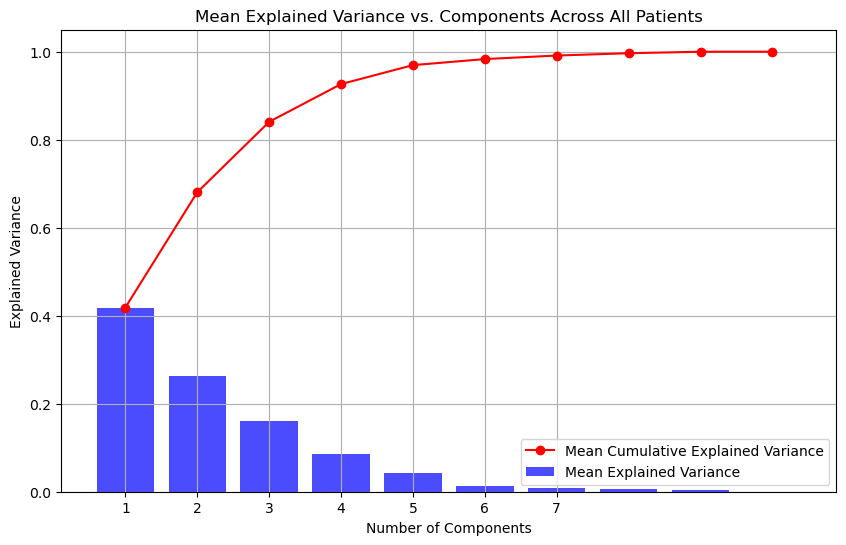

Optimal number of components (averaged across all patients): 5


In [74]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from sklearn.decomposition import PCA

# Function to perform PCA, average results across patients, and plot the cumulative explained variance
def perform_pca_and_average(patient_data, features, threshold=0.95):
    cumulative_variances = []
    explained_variances = []

    for patient, data in patient_data.items():
        # Extract the feature columns for PSD analysis
        X = data[features].values

        # Apply PCA
        pca = PCA()
        X_pca = pca.fit_transform(X)

        # Explained variance ratio and cumulative variance for the current patient
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)

        # Collect cumulative variances and explained variance ratios
        cumulative_variances.append(cumulative_variance)
        explained_variances.append(explained_variance_ratio)

    # Compute the average cumulative variance and explained variance across all patients
    mean_cumulative_variance = np.mean(cumulative_variances, axis=0)
    mean_explained_variance = np.mean(explained_variances, axis=0)

    # Find the optimal number of components based on the average cumulative variance
    optimal_components = np.argmax(mean_cumulative_variance >= threshold) + 1

    # Plot the averaged explained variance and cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mean_explained_variance) + 1), mean_explained_variance, alpha=0.7, label='Mean Explained Variance', color='blue')
    plt.plot(range(1, len(mean_cumulative_variance) + 1), mean_cumulative_variance, marker='o', color='red', label='Mean Cumulative Explained Variance')

    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.title('Mean Explained Variance vs. Components Across All Patients')
    plt.xticks(range(1, min(8, len(mean_explained_variance) + 1)))  # Limit x-axis to 1, 2, 3, ..., up to 7
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    print(f'Optimal number of components (averaged across all patients): {optimal_components}')
    
    return optimal_components

# Define the list of PSD features for PCA
features = ['PSD Delta', 'PSD Delta_N', 'PSD Theta', 'PSD Theta_N', 'PSD Alpha', 'PSD Alpha_N', 
            'PSD Beta', 'PSD Beta_N', 'PSD Gamma', 'PSD Gamma_N']

# Perform PCA, average the results across all patients, and plot
optimal_components = perform_pca_and_average(patient_data, features)

## GMM

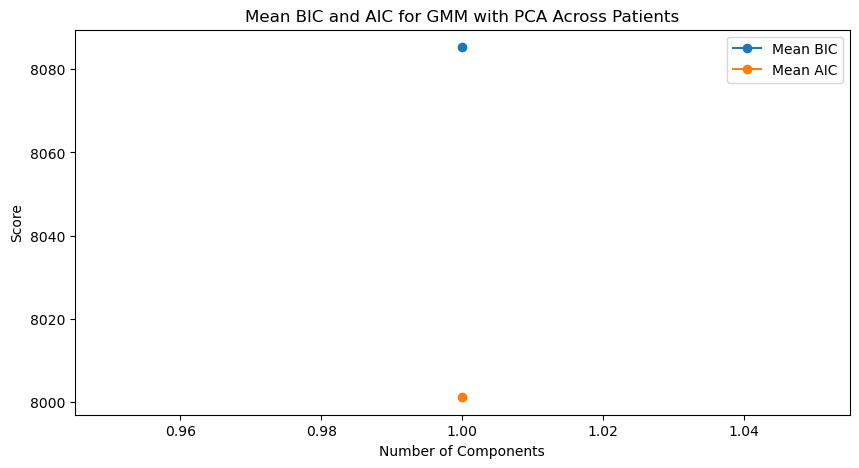

Optimal number of components based on mean BIC: 1
Optimal number of components based on mean AIC: 1


(1, 1)

In [75]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def find_optimal_gmm_components_mean(patient_data, max_components=10, n_pca_components=5):
    # Initialize lists to store BIC and AIC scores for each patient
    bic_scores_all = []
    aic_scores_all = []
    
    # Range for the number of components
    n_components_range = np.arange(1, max_components + 1)

    # Loop through each patient's data and compute BIC and AIC
    for patient, data in patient_data.items():
        # Apply PCA to reduce dimensionality
        X = data[features].values
        pca = PCA(n_components=n_pca_components)
        reduced_data = pca.fit_transform(X)
        
        # Lists to store BIC and AIC scores for this patient
        bic_scores = []
        aic_scores = []
        
        # Fit GMM for each number of components
        for n_components in n_components_range:
            gmm = GaussianMixture(n_components=n_components, random_state=0)
            gmm.fit(reduced_data)
            
            # Append BIC and AIC scores
            bic_scores.append(gmm.bic(reduced_data))
            aic_scores.append(gmm.aic(reduced_data))
        
        # Store the BIC and AIC scores for this patient
        bic_scores_all.append(bic_scores)
        aic_scores_all.append(aic_scores)
    
    # Compute the mean BIC and AIC scores across all patients
    mean_bic_scores = np.mean(bic_scores_all, axis=0)
    mean_aic_scores = np.mean(aic_scores_all, axis=0)

    # Plot the mean BIC and AIC scores
    plt.figure(figsize=(10, 5))
    plt.plot(n_components_range, mean_bic_scores, label='Mean BIC', marker='o')
    plt.plot(n_components_range, mean_aic_scores, label='Mean AIC', marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Score')
    plt.title('Mean BIC and AIC for GMM with PCA Across Patients')
    plt.legend()
    plt.show()

    # Find the optimal number of components based on the mean BIC and AIC
    optimal_n_components_bic = n_components_range[np.argmin(mean_bic_scores)]
    optimal_n_components_aic = n_components_range[np.argmin(mean_aic_scores)]
    
    print(f'Optimal number of components based on mean BIC: {optimal_n_components_bic}')
    print(f'Optimal number of components based on mean AIC: {optimal_n_components_aic}')
    
    return optimal_n_components_bic, optimal_n_components_aic

find_optimal_gmm_components_mean(patient_data, max_components=1, n_pca_components=5)

# Gaussian Mixture Model Training & Plotting 

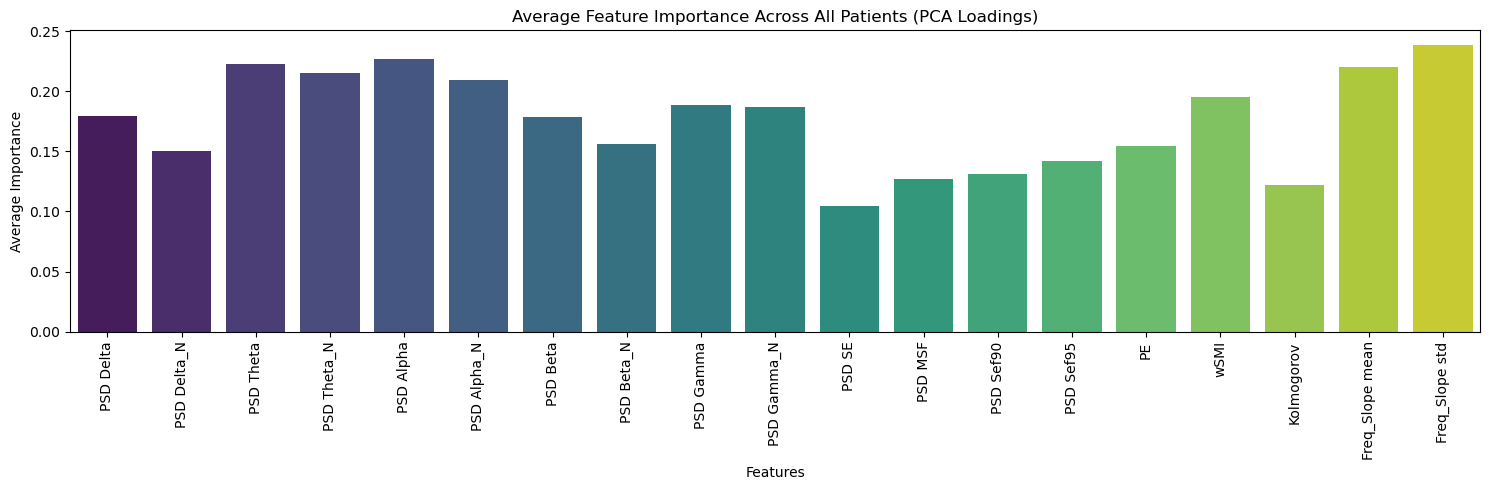

In [76]:
# Function to calculate and plot feature importance across all patients
def plot_feature_importance_all_patients(patient_data, n_components=5):
    feature_names = ['PSD Delta', 'PSD Delta_N', 'PSD Theta', 'PSD Theta_N', 'PSD Alpha', 'PSD Alpha_N',
                     'PSD Beta', 'PSD Beta_N', 'PSD Gamma', 'PSD Gamma_N', 'PSD SE', 'PSD MSF', 'PSD Sef90',
                     'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']

    # Initialize list to store feature importances for each patient
    feature_importances = []

    for patient, data in patient_data.items():
        # Standardize data
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(data[feature_names])
        
        # Apply PCA
        pca = PCA(n_components=n_components)
        pca.fit(standardized_data)
        
        # Get absolute loadings (contribution of each feature to each principal component)
        loadings = np.abs(pca.components_).mean(axis=0)
        feature_importances.append(loadings)

    # Average feature importances across all patients
    avg_importances = np.mean(feature_importances, axis=0)

    # Plotting the average feature importance
    plt.figure(figsize=(15, 5))
    sns.barplot(x=feature_names, y=avg_importances, palette='viridis')
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Average Importance')
    plt.title('Average Feature Importance Across All Patients (PCA Loadings)')
    plt.tight_layout()
    plt.show()

# Example call to plot feature importance across all patients
plot_feature_importance_all_patients(patient_data, n_components=5)


In [77]:
def plot_all_patients(patient_data, n_components=5):
    for patient in patient_data.keys():
        print(f"Plotting for patient: {patient}")
        gmm_clustering_training_and_plotting(patient, n_components)


In [78]:
def gmm_clustering_training_and_plotting(patient, n_components, sigma=0.1):
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    
    pca = PCA(n_components=5)
    reduced_data = pca.fit_transform(patient_data[patient])

    

    gmm.fit(reduced_data)
    
    labels = gmm.predict(reduced_data)
    
    # ----------- PLOTTING ----------- 
    patient_data_with_labels = patient_data[patient].copy()
    patient_data_with_labels['Cluster Label'] = labels

    fig, ax = plt.subplots(figsize=(10, 5))

    cluster_colors = ['red' if label == 0 else 'blue' for label in labels]

    scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_colors, marker='o', edgecolor='black', linewidth=0.5, s=30)
    ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=100, c='black', marker='x', label='Cluster Means')
    ax.set_title(f"Clusters for Patient {patient}", fontsize=10)  
    ax.grid(False)

    fig, ax2 = plt.subplots(figsize=(10, 5))
    
    time = np.arange(len(patient_data_with_labels))
    delta_smooth = gaussian_filter1d(patient_data_with_labels['PSD Delta'], sigma=sigma)
    theta_smooth = gaussian_filter1d(patient_data_with_labels['PSD Theta'], sigma=sigma)
    beta_smooth = gaussian_filter1d(patient_data_with_labels['PSD Beta'], sigma=sigma)
    gamma_smooth = gaussian_filter1d(patient_data_with_labels['PSD Gamma'], sigma=sigma)
    
    ax2.plot(time, delta_smooth, label='Delta (0.5-4 Hz)', color='black', linewidth=1)
    ax2.plot(time, theta_smooth, label='Theta (4-8 Hz)', color='gray', linewidth=1)
    ax2.plot(time, beta_smooth, label='Beta (12-30 Hz)', color='darkgray', linewidth=1)
    ax2.plot(time, gamma_smooth, label='Gamma (>30 Hz)', color='dimgray', linewidth=1)

    ax2.scatter(time, patient_data_with_labels['PSD Delta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Delta)', zorder=3)
    ax2.scatter(time, patient_data_with_labels['PSD Theta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Theta)', zorder=3)
    ax2.scatter(time, patient_data_with_labels['PSD Beta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Beta)', zorder=3)
    ax2.scatter(time, patient_data_with_labels['PSD Gamma'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Gamma)', zorder=3)

    stimuli_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen'}  # 0=R, 1=M, 2=F
    
    event_groups = patient_data_with_labels['Event'].ne(patient_data_with_labels['Event'].shift()).cumsum()
    
    for _, group_data in patient_data_with_labels.groupby(event_groups):
        stimulus_value = group_data['Event'].iloc[0]
        if stimulus_value in stimuli_colors:
            start_idx = group_data.index[0]
            end_idx = group_data.index[-1]
            start_time = time[start_idx]
            end_time = time[end_idx]
            ax2.axvspan(start_time, end_time, color=stimuli_colors[stimulus_value], alpha=0.3, zorder=1)
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster 0', markerfacecolor='red', markersize=8, markeredgecolor='black'),
                       Line2D([0], [0], marker='o', color='w', label='Cluster 1', markerfacecolor='blue', markersize=8, markeredgecolor='black')]
    ax2.legend(handles=legend_elements, fontsize=8, loc='upper right')

    ax2.set_title(f'EEG Features with Clusters for Patient {patient}', fontsize=10)
    ax2.set_xlabel('Sample Index')
    ax2.set_ylabel('Feature Value')
    ax2.grid(False)
    silhouette_avg = silhouette_score(reduced_data, labels)
    print(f'Silhouette Score: {silhouette_avg}')

    db_score = davies_bouldin_score(reduced_data, labels)
    print(f'Davies-Bouldin Index: {db_score}')

    plt.tight_layout()
    plt.show()


# Visual Representation

Silhouette Score: 0.6965244216052598
Davies-Bouldin Index: 0.3739738922059496


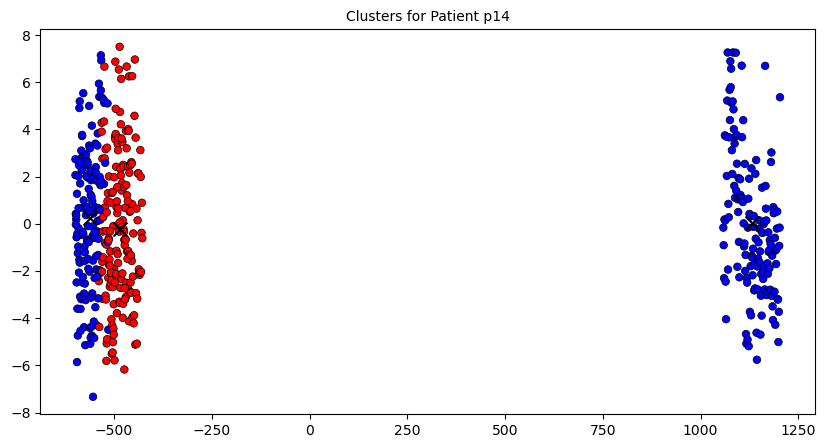

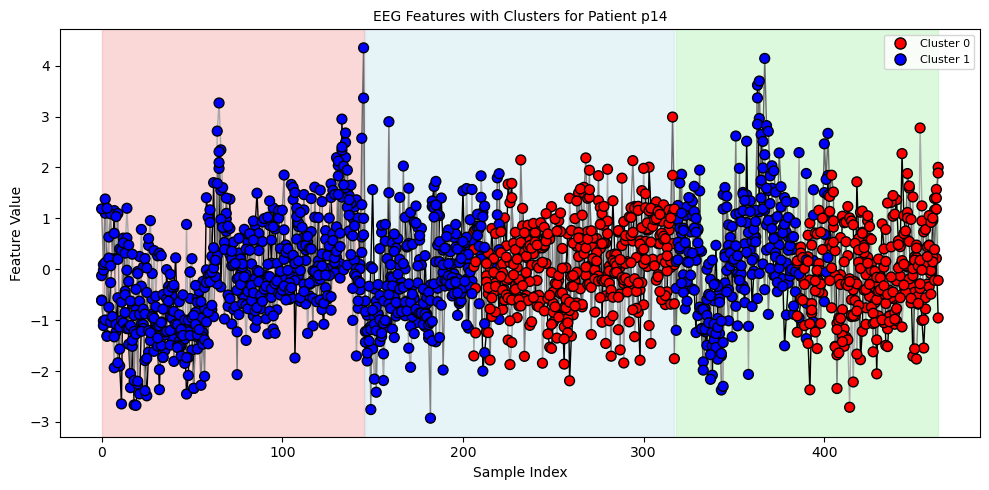

Silhouette Score: 0.3012883583862397
Davies-Bouldin Index: 5.500095601436027


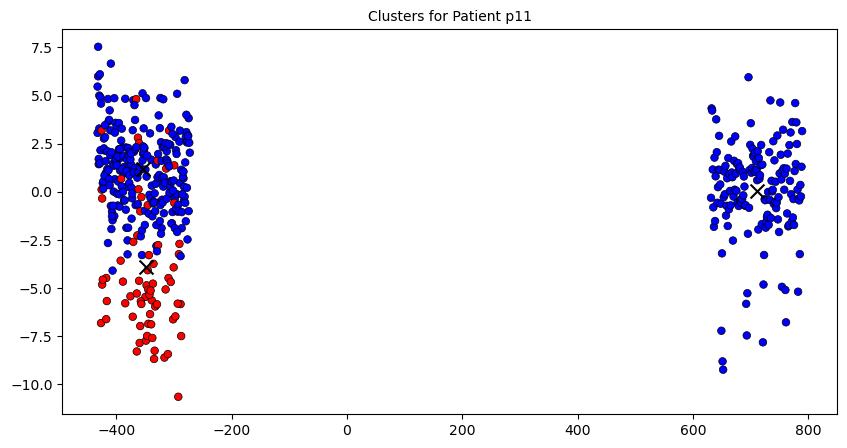

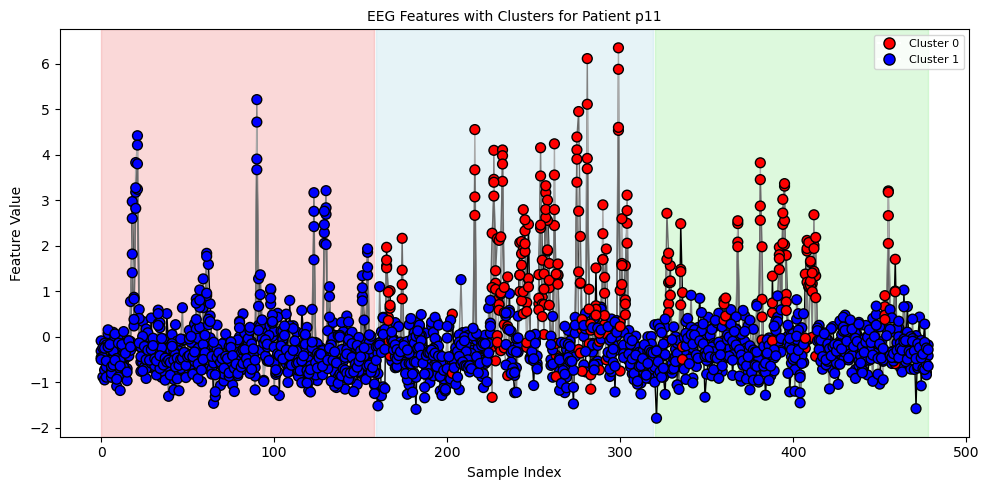

Silhouette Score: 0.7032129098798496
Davies-Bouldin Index: 0.37297495409996767


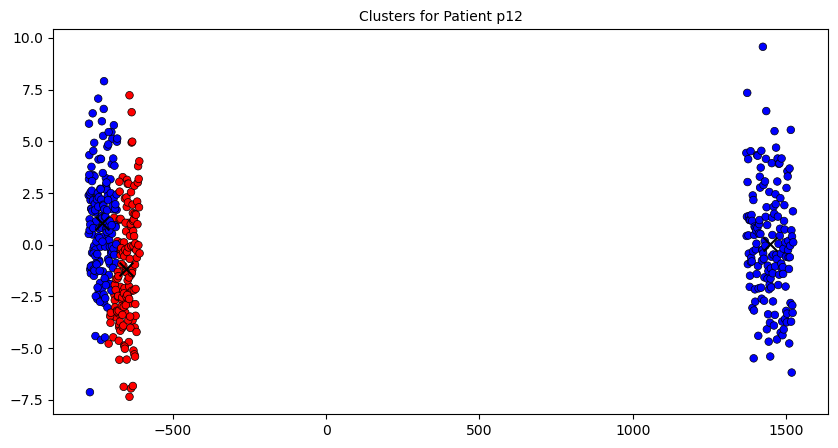

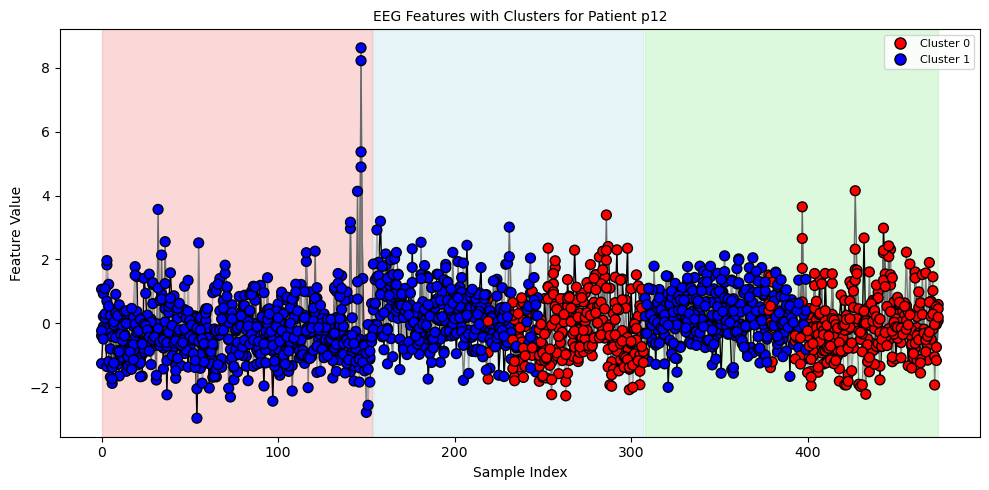

In [79]:
patient_examples = ['p14','p11','p12']
for patient in patient_examples:
    gmm_clustering_training_and_plotting(patient, n_components=3)

# Other plots

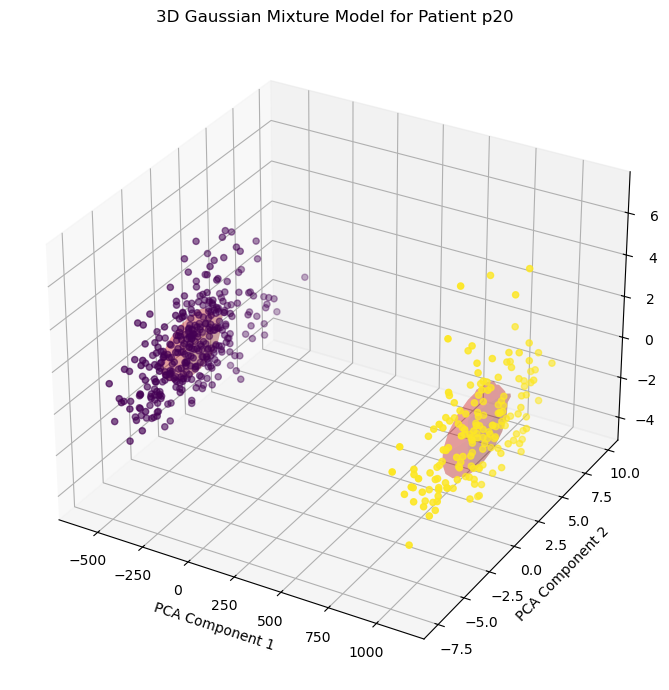

In [26]:
def plot_gmm_3d(gmm, data, labels, ax):
    # Function to plot 3D ellipsoids representing the Gaussian components
    def draw_ellipse(position, covariance, ax, **kwargs):
        """ Draw an ellipse for each Gaussian component based on the covariance """
        if covariance.shape == (3, 3):
            U, s, rotation = np.linalg.svd(covariance)
            radii = np.sqrt(s)
            u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
            x = np.cos(u)*np.sin(v)
            y = np.sin(u)*np.sin(v)
            z = np.cos(v)
            points = np.stack((x, y, z), axis=-1)

            for j in range(points.shape[0]):
                for i in range(points.shape[1]):
                    points[j, i, :] = radii * np.dot(rotation, points[j, i, :])

            x, y, z = points[..., 0] + position[0], points[..., 1] + position[1], points[..., 2] + position[2]
            ax.plot_surface(x, y, z, rstride=4, cstride=4, color='r', alpha=0.2)
    
    # Plot data points
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, s=20, cmap=cm.viridis, zorder=2)

    # Plot ellipsoids for each component
    for pos, covar in zip(gmm.means_, gmm.covariances_):
        draw_ellipse(pos, covar, ax)

def gmm_clustering_training_and_plotting_3d(patient):
    # Initialize GMM
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
    
    # PCA to reduce data to 3 dimensions
    pca = PCA(n_components=3)
    reduced_data = pca.fit_transform(patient_data[patient])
    
    # Fit GMM and predict labels
    gmm.fit(reduced_data)
    labels = gmm.predict(reduced_data)
    
    # Plot the 3D data and Gaussian ellipsoids
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_title(f'3D Gaussian Mixture Model for Patient {patient}')
    plot_gmm_3d(gmm, reduced_data, labels, ax)
    
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    
    plt.tight_layout()
    plt.show()

gmm_clustering_training_and_plotting_3d('p20')

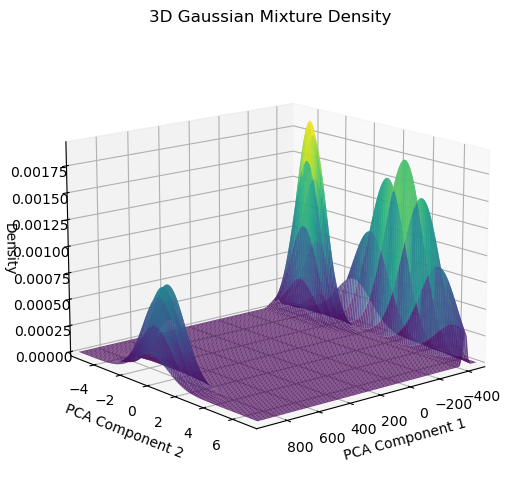

In [27]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate grid for 3D plot
def generate_grid(data, num_points=100):
    x = np.linspace(data[:, 0].min(), data[:, 0].max(), num_points)
    y = np.linspace(data[:, 1].min(), data[:, 1].max(), num_points)
    X, Y = np.meshgrid(x, y)
    grid = np.array([X.ravel(), Y.ravel()]).T
    return X, Y, grid

def plot_gmm_density_3d(patient_data, num_components=2, azim=45, elev=30):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(patient_data)

    gmm = GaussianMixture(n_components=num_components, covariance_type='full')
    gmm.fit(reduced_data)
    
    X, Y, grid = generate_grid(reduced_data)
    
    density = np.exp(gmm.score_samples(grid))
    
    Z = density.reshape(X.shape)
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.8)
    
    ax.set_title('3D Gaussian Mixture Density')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('Density')

    ax.view_init(elev=elev, azim=azim)

    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())
    ax.set_zlim(0, Z.max())
    
    plt.show()


plot_gmm_density_3d(patient_data['p50'], num_components=5, azim=50, elev=15)


In [102]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

# Assuming patient_data dictionary and data preprocessing are defined elsewhere

# Function to combine and plot clusters, time graph, and feature importance for each patient
def combined_plot_for_each_patient(patient_data, patients, n_components_pca=5, n_components_gmm=3, sigma=0.1):
    feature_names = ['PSD Delta', 'PSD Delta_N', 'PSD Theta', 'PSD Theta_N', 'PSD Alpha', 'PSD Alpha_N',
                     'PSD Beta', 'PSD Beta_N', 'PSD Gamma', 'PSD Gamma_N', 'PSD SE', 'PSD MSF', 'PSD Sef90',
                     'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']

    for patient in patients:
        if patient not in patient_data:
            print(f"Patient {patient} not found in patient_data.")
            continue

        data = patient_data[patient]
        print(f"Plotting combined plots for patient: {patient}")        

        # Apply PCA
        pca = PCA(n_components=n_components_pca)
        reduced_data = pca.fit_transform(data)
        
        # Fit GMM
        gmm = GaussianMixture(n_components=n_components_gmm, random_state=0)
        gmm.fit(reduced_data)
        labels = gmm.predict(reduced_data)
        
        # Get feature importance (contribution of original features)
        # Each principal component is a linear combination of the original features
        # To get feature importance, we calculate the sum of the absolute values of the loadings
        feature_contributions = np.sum(np.abs(pca.components_), axis=0)

        # Ensure feature_contributions and feature_names have the same length
        if len(feature_contributions) != len(feature_names):
            feature_contributions = feature_contributions[:len(feature_names)]

        # Prepare patient data with labels for plotting
        patient_data_with_labels = data.copy()
        patient_data_with_labels['Cluster Label'] = labels

        # Create figure for combined plots
        fig, axes = plt.subplots(3, 1, figsize=(15, 15))
        
        # Plot 1: Clusters
        ax = axes[0]
        cluster_colors = ['red' if label == 0 else 'blue' for label in labels]
        scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_colors, marker='o', edgecolor='black', linewidth=0.5, s=30)
        ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=100, c='black', marker='x', label='Cluster Means')
        ax.set_title(f"Clusters for Patient {patient}", fontsize=10)  
        ax.grid(False)
        
        # Plot 2: Time Graph of EEG Features
        ax2 = axes[1]
        time = np.arange(len(patient_data_with_labels))
        delta_smooth = gaussian_filter1d(patient_data_with_labels['PSD Delta'], sigma=sigma)
        theta_smooth = gaussian_filter1d(patient_data_with_labels['PSD Theta'], sigma=sigma)
        beta_smooth = gaussian_filter1d(patient_data_with_labels['PSD Beta'], sigma=sigma)
        gamma_smooth = gaussian_filter1d(patient_data_with_labels['PSD Gamma'], sigma=sigma)
        
        ax2.plot(time, delta_smooth, label='Delta (0.5-4 Hz)', color='black', linewidth=1)
        ax2.plot(time, theta_smooth, label='Theta (4-8 Hz)', color='gray', linewidth=1)
        ax2.plot(time, beta_smooth, label='Beta (12-30 Hz)', color='darkgray', linewidth=1)
        ax2.plot(time, gamma_smooth, label='Gamma (>30 Hz)', color='dimgray', linewidth=1)

        ax2.scatter(time, patient_data_with_labels['PSD Delta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Delta)', zorder=3)
        ax2.scatter(time, patient_data_with_labels['PSD Theta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Theta)', zorder=3)
        ax2.scatter(time, patient_data_with_labels['PSD Beta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Beta)', zorder=3)
        ax2.scatter(time, patient_data_with_labels['PSD Gamma'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Gamma)', zorder=3)

        stimuli_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen'}  # 0=R, 1=M, 2=F
        
        event_groups = patient_data_with_labels['Event'].ne(patient_data_with_labels['Event'].shift()).cumsum()
        
        for _, group_data in patient_data_with_labels.groupby(event_groups):
            stimulus_value = group_data['Event'].iloc[0]
            if stimulus_value in stimuli_colors:
                start_idx = group_data.index[0]
                end_idx = group_data.index[-1]
                start_time = time[start_idx]
                end_time = time[end_idx]
                ax2.axvspan(start_time, end_time, color=stimuli_colors[stimulus_value], alpha=0.3, zorder=1)
        
        ax2.set_title(f'EEG Features with Clusters for Patient {patient}', fontsize=10)
        ax2.set_xlabel('Sample Index')
        ax2.set_ylabel('Feature Value')
        ax2.grid(False)

        # Plot 3: Feature Importance (Contribution of Original Features)
        ax3 = axes[2]
        sns.barplot(x=feature_names[:len(feature_contributions)], y=feature_contributions, palette='viridis', ax=ax3)
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
        ax3.set_xlabel('Features')
        ax3.set_ylabel('Contribution')
        ax3.set_title(f'Feature Contribution for Patient {patient} (PCA Loadings)')

        plt.tight_layout()
        plt.show()
        plt.pause(0.1)

In [ ]:
# Example call to create combined plots for each patient
patients = ['p10', 'p11', 'p12']
combined_plot_for_each_patient(patient_data, patients, n_components_pca=5, n_components_gmm=3, sigma=0.1)


Plotting combined plots for patient: p10


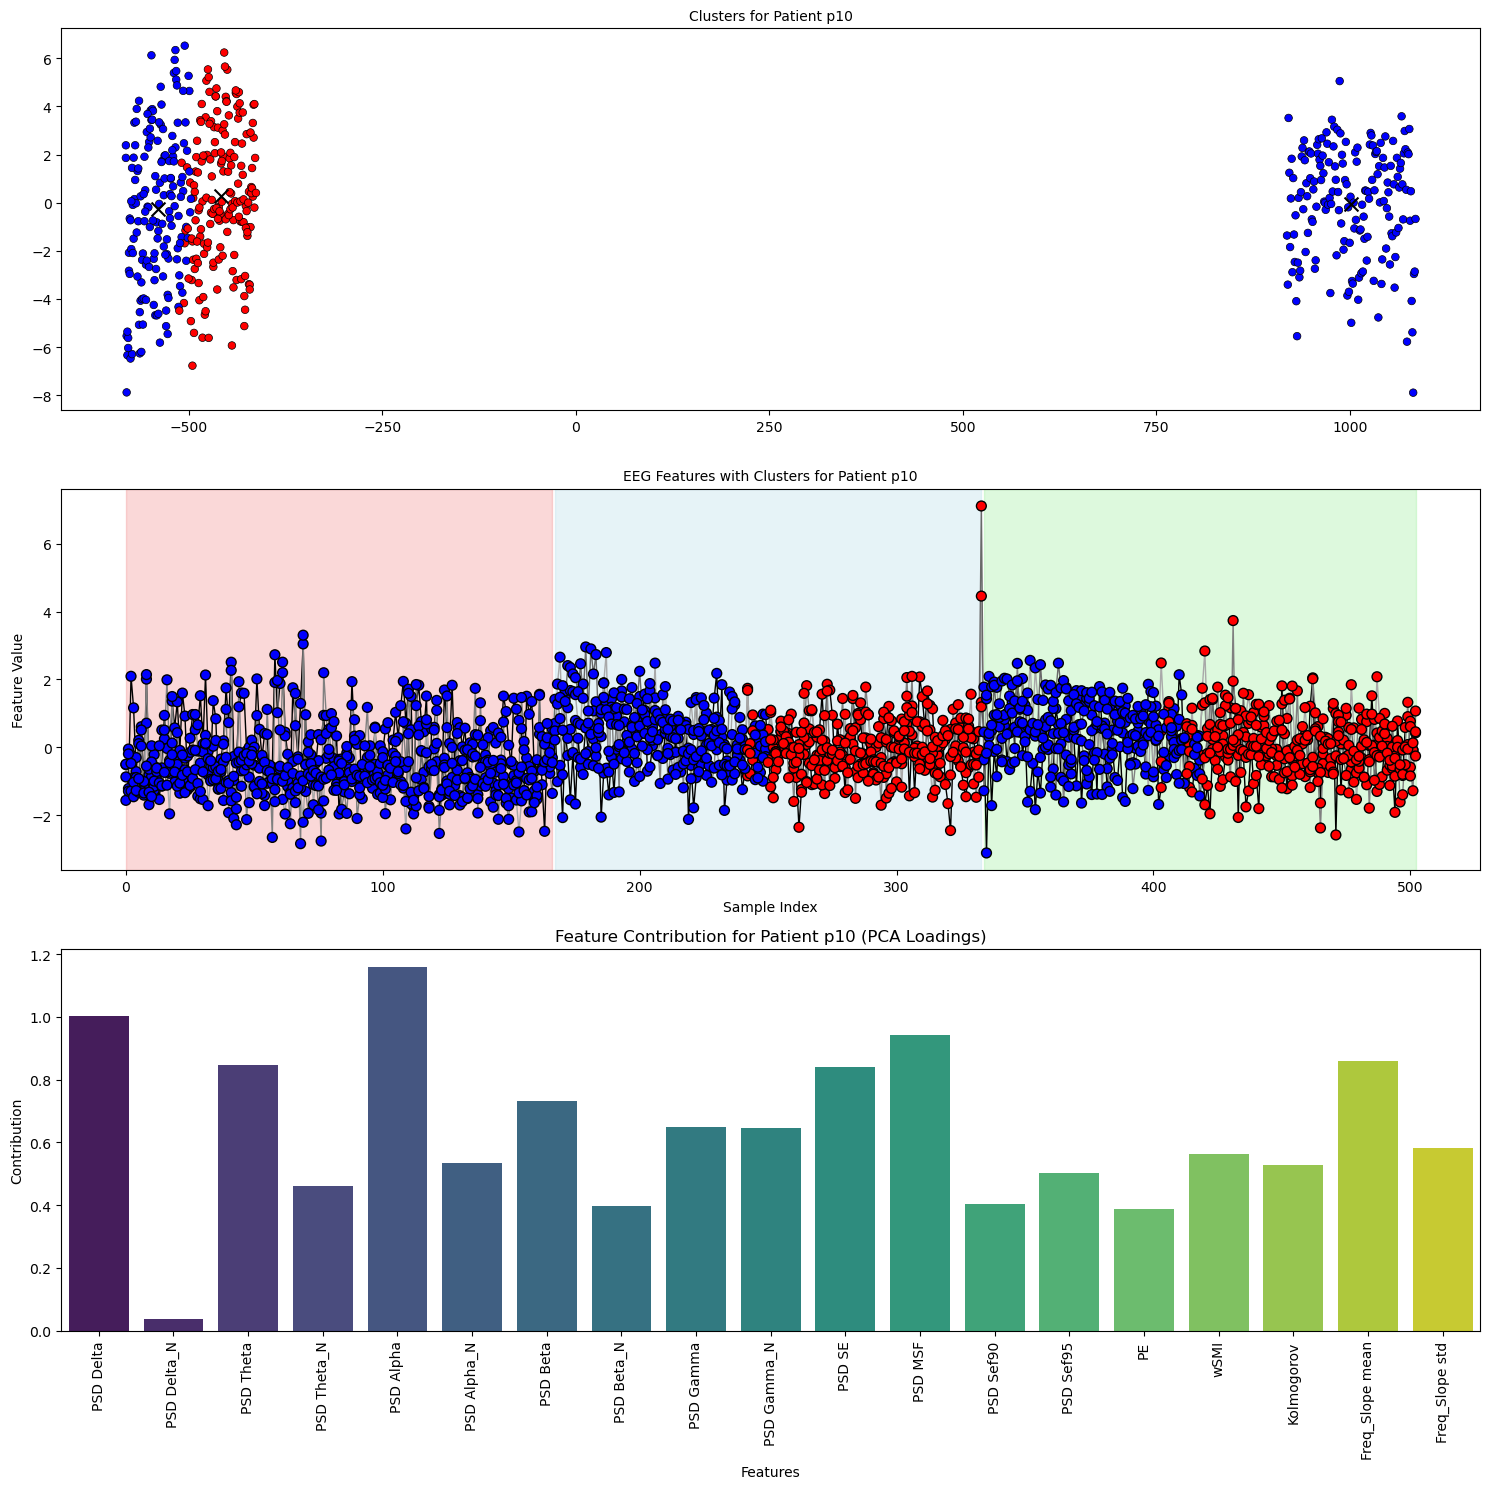

Plotting combined plots for patient: p11


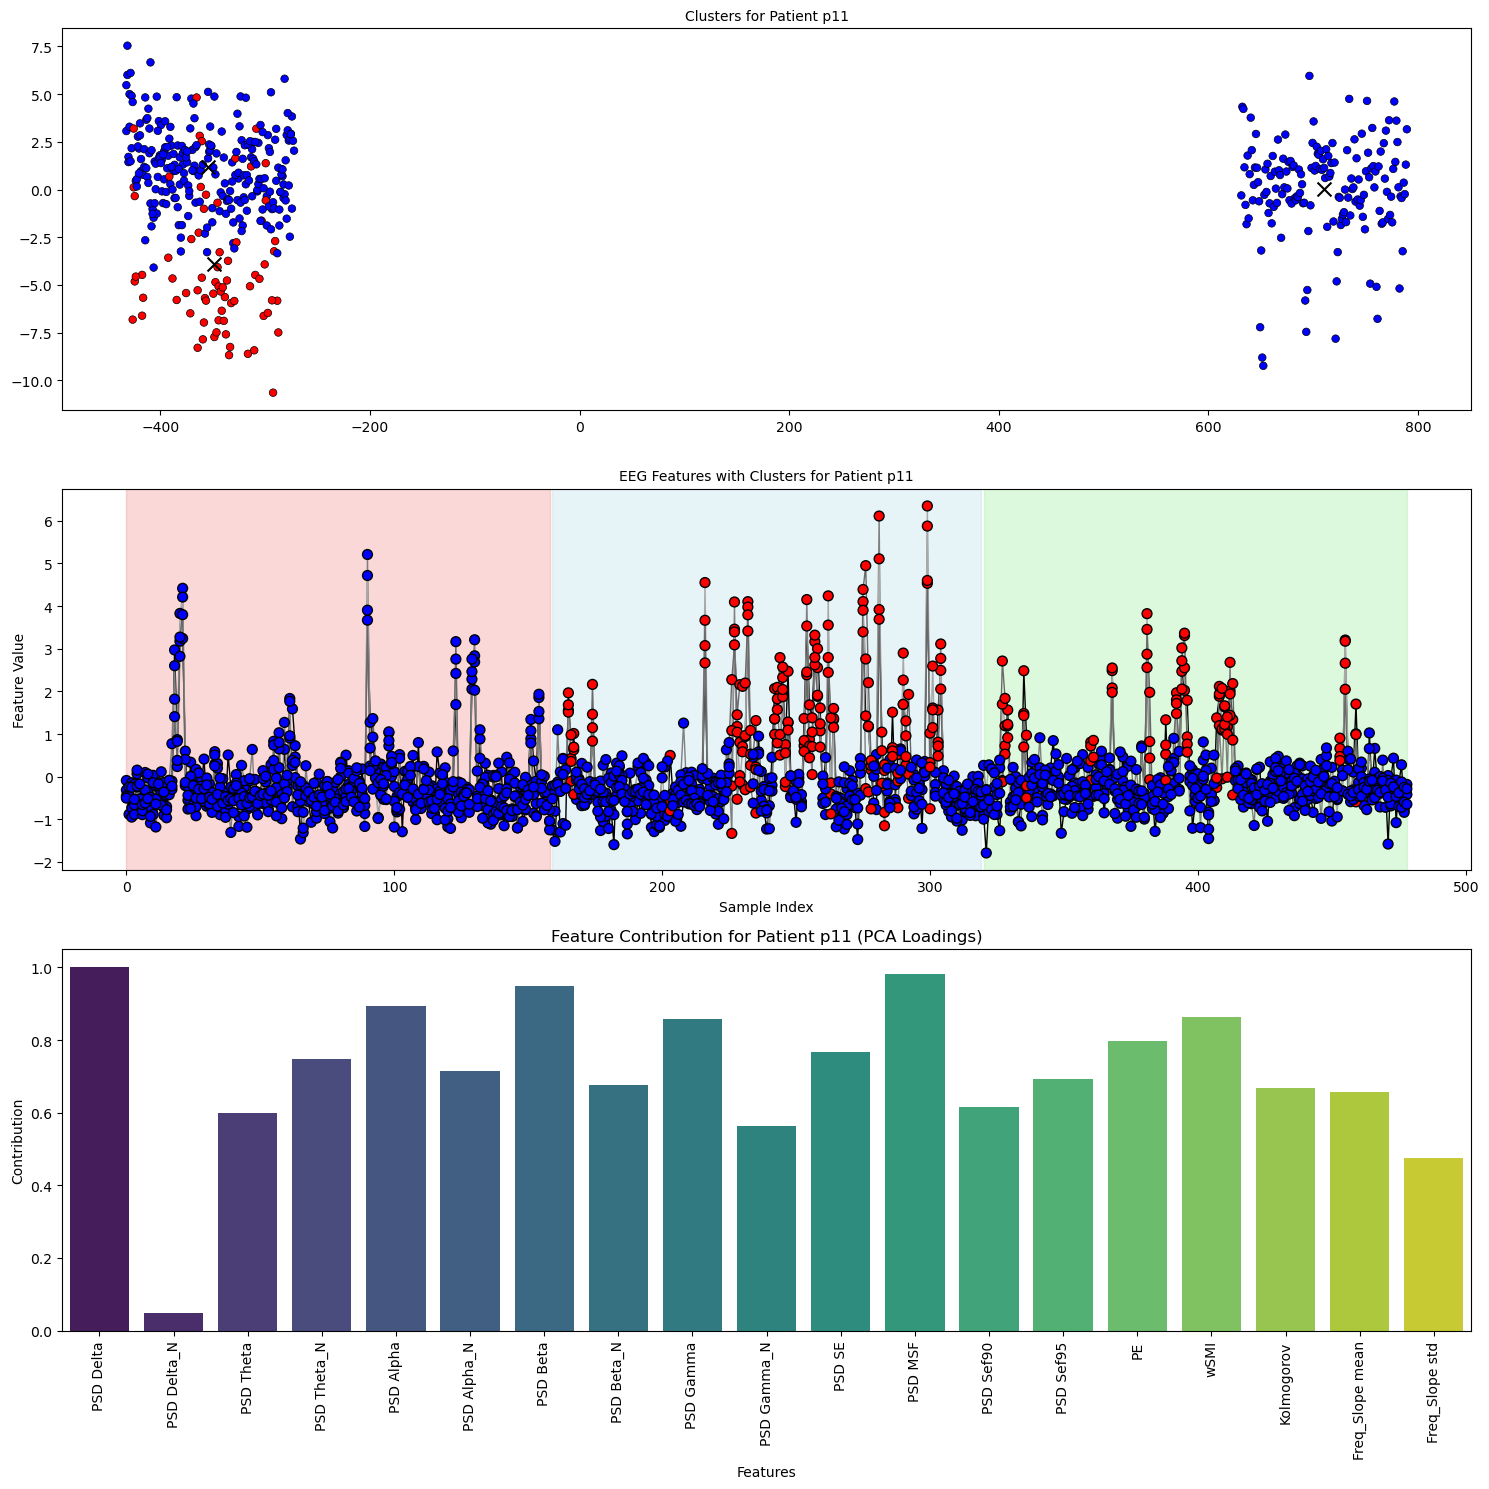

Plotting combined plots for patient: p12


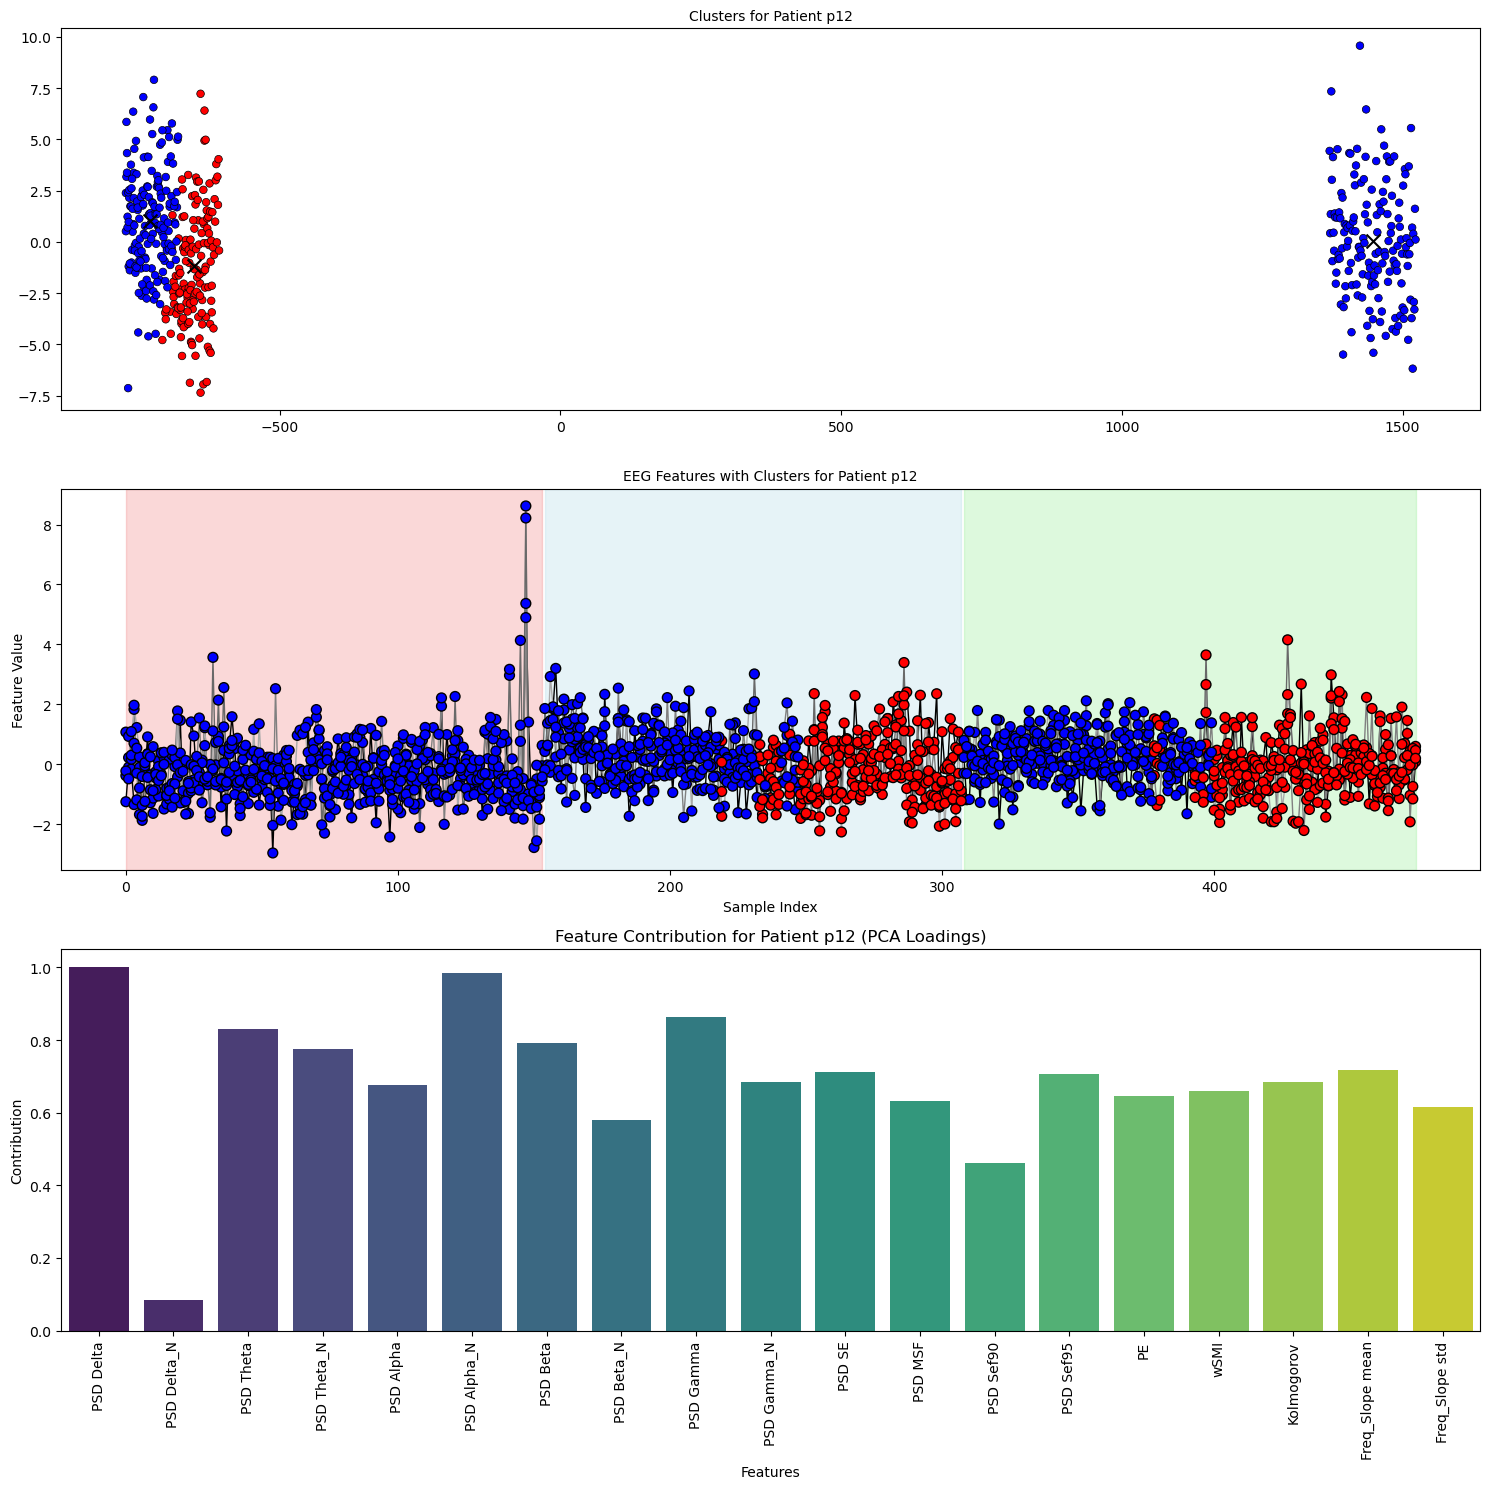

In [112]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# Assuming patient_data dictionary and data preprocessing are defined elsewhere

# Function to combine and plot clusters, time graph, and feature importance for each patient
def combined_plot_for_each_patient(patient_data, patients, n_components_pca=5, n_components_gmm=3, save_to_pdf=False, output_pdf_path='combined_patient_plots.pdf'):
    feature_names = ['PSD Delta', 'PSD Delta_N', 'PSD Theta', 'PSD Theta_N', 'PSD Alpha', 'PSD Alpha_N',
                     'PSD Beta', 'PSD Beta_N', 'PSD Gamma', 'PSD Gamma_N', 'PSD SE', 'PSD MSF', 'PSD Sef90',
                     'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']

    if save_to_pdf:
        pdf = PdfPages(output_pdf_path)
    
    for patient in patients:
        if patient not in patient_data:
            print(f"Patient {patient} not found in patient_data.")
            continue

        data = patient_data[patient]
        print(f"Plotting combined plots for patient: {patient}")        

        # Apply PCA
        pca = PCA(n_components=n_components_pca)
        reduced_data = pca.fit_transform(data)
        
        # Fit GMM
        gmm = GaussianMixture(n_components=n_components_gmm, random_state=0)
        gmm.fit(reduced_data)
        labels = gmm.predict(reduced_data)
        
        # Get feature importance (contribution of original features)
        # Each principal component is a linear combination of the original features
        # To get feature importance, we calculate the sum of the absolute values of the loadings
        feature_contributions = np.sum(np.abs(pca.components_), axis=0)

        # Ensure feature_contributions and feature_names have the same length
        if len(feature_contributions) != len(feature_names):
            feature_contributions = feature_contributions[:len(feature_names)]

        # Prepare patient data with labels for plotting
        patient_data_with_labels = data.copy()
        patient_data_with_labels['Cluster Label'] = labels

        # Create figure for combined plots
        fig, axes = plt.subplots(3, 1, figsize=(15, 15))
        
        # Plot 1: Clusters
        ax = axes[0]
        cluster_colors = ['red' if label == 0 else 'blue' for label in labels]
        scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_colors, marker='o', edgecolor='black', linewidth=0.5, s=30)
        ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=100, c='black', marker='x', label='Cluster Means')
        ax.set_title(f"Clusters for Patient {patient}", fontsize=10)  
        ax.grid(False)
        
        # Plot 2: Time Graph of EEG Features
        ax2 = axes[1]
        time = np.arange(len(patient_data_with_labels))
        
        ax2.plot(time, patient_data_with_labels['PSD Delta'], label='Delta (0.5-4 Hz)', color='black', linewidth=1)
        ax2.plot(time, patient_data_with_labels['PSD Theta'], label='Theta (4-8 Hz)', color='gray', linewidth=1)
        ax2.plot(time, patient_data_with_labels['PSD Beta'], label='Beta (12-30 Hz)', color='darkgray', linewidth=1)
        ax2.plot(time, patient_data_with_labels['PSD Gamma'], label='Gamma (>30 Hz)', color='dimgray', linewidth=1)

        ax2.scatter(time, patient_data_with_labels['PSD Delta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Delta)', zorder=3)
        ax2.scatter(time, patient_data_with_labels['PSD Theta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Theta)', zorder=3)
        ax2.scatter(time, patient_data_with_labels['PSD Beta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Beta)', zorder=3)
        ax2.scatter(time, patient_data_with_labels['PSD Gamma'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Gamma)', zorder=3)

        stimuli_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen'}  # 0=R, 1=M, 2=F
        
        event_groups = patient_data_with_labels['Event'].ne(patient_data_with_labels['Event'].shift()).cumsum()
        
        for _, group_data in patient_data_with_labels.groupby(event_groups):
            stimulus_value = group_data['Event'].iloc[0]
            if stimulus_value in stimuli_colors:
                start_idx = group_data.index[0]
                end_idx = group_data.index[-1]
                start_time = time[start_idx]
                end_time = time[end_idx]
                ax2.axvspan(start_time, end_time, color=stimuli_colors[stimulus_value], alpha=0.3, zorder=1)
        
        ax2.set_title(f'EEG Features with Clusters for Patient {patient}', fontsize=10)
        ax2.set_xlabel('Sample Index')
        ax2.set_ylabel('Feature Value')
        ax2.grid(False)

        # Plot 3: Feature Importance (Contribution of Original Features)
        ax3 = axes[2]
        sns.barplot(x=feature_names[:len(feature_contributions)], y=feature_contributions, palette='viridis', ax=ax3)
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
        ax3.set_xlabel('Features')
        ax3.set_ylabel('Contribution')
        ax3.set_title(f'Feature Contribution for Patient {patient} (PCA Loadings)')

        plt.tight_layout()
        
        if save_to_pdf:
            pdf.savefig(fig)
            plt.close(fig)
        else:
            plt.show()
            plt.pause(0.1)

    if save_to_pdf:
        pdf.close()

# Example call to create combined plots for each patient
patients = ['p10', 'p11', 'p12']
combined_plot_for_each_patient(patient_data, patients, n_components_pca=5, n_components_gmm=3)

# Example call to save combined plots for each patient to a PDF
#combined_plot_for_each_patient(patient_data, patients, n_components_pca=5, n_components_gmm=3, sigma=0.1, save_to_pdf=True, output_pdf_path='combined_patient_plots.pdf')